In [1]:
from AutoClass import AutoClassImpute, take_norm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
import matplotlib.colors as mc
import colorsys
def lighten_color(color, amount=0.5):
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

In [3]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,adjusted_rand_score,normalized_mutual_info_score
from sklearn.metrics.cluster import contingency_matrix
from sklearn.preprocessing import StandardScaler
import warnings
def purity_score(y_true, y_pred):
    # compute contingency matrix (also called confusion matrix)
    contingency_matrix1 = contingency_matrix(y_true, y_pred)
    # return purity
    return np.sum(np.amax(contingency_matrix1, axis=0)) / np.sum(contingency_matrix1) 
 
def batch_clus(tsne,label,batch):
    ncell = len(label)
    Kb = 3
    unique_celltype = np.unique(label)  
    warnings.filterwarnings("ignore")
    df = pd.DataFrame()
    tsnesil,tsneari,tsnenmi,tsneps,tsneji = 0,0,0,0,0
    for i in unique_celltype:
        kmeans_tsne = KMeans(n_clusters=Kb,random_state=1).fit(
                (tsne[label==i,:]))
        clusterlabel_tsne = kmeans_tsne.labels_
        tsnesil = tsnesil + silhouette_score(StandardScaler(
                ).fit_transform(tsne[label==i,:]),batch[label==i])*np.sum(label==i)
        tsnenmi = tsnenmi + normalized_mutual_info_score(batch[label==i],clusterlabel_tsne)*np.sum(label==i)
        tsneari = tsneari + adjusted_rand_score(batch[label==i],clusterlabel_tsne)*np.sum(label==i)
        tsneps = tsneps + purity_score(batch[label==i],clusterlabel_tsne)*np.sum(label==i)
    df['1-ASW'] = [np.round(1-tsnesil/ncell,3)]
    df['1-ARI']=[np.round(1-tsneari/ncell,3)]
    df['1-NMI'] = [np.round(1-tsnenmi/ncell,3)]
    df['1-PS'] = [np.round(1-tsneps/ncell,3)]
            
    return df
def celltype_clus(tsne,label):
    unique_celltype = np.unique(label)  
    K = len(unique_celltype)
    warnings.filterwarnings("ignore")
    df = pd.DataFrame()
    kmeans = KMeans(n_clusters = K,random_state=1).fit(tsne)
    cluster_label = kmeans.labels_
    df['ASW'] = [np.round(silhouette_score(tsne,label),3)]
    df['ARI'] = [np.round(adjusted_rand_score(label,cluster_label),3)]
    df['NMI'] = [np.round(normalized_mutual_info_score(label,cluster_label),3)]
    df['PS'] = [np.round(purity_score(label,cluster_label),3)]
    return df

In [4]:
expr = pd.read_csv('C:/Users/hli45/Desktop/auto_code/Baron.csv',index_col=0)
celltype = expr.values[:,-2]
batchID = expr.values[:,-1]
Y = pd.factorize(celltype)[0]
unique_class = np.unique(Y)   
X = expr.values[:,:-2].astype('float32')
K = len(np.unique(Y))
X_norm = take_norm(X)
ncell,ngene = X.shape[0], X.shape[1] 
print('{} cells, {} genes \nproportion of 0s: {} \n{} different cell types'.format(ncell,ngene,np.mean(X==0),K))
print('{} batches'.format(len(np.unique(batchID))))

7162 cells, 1000 genes 
proportion of 0s: 0.8220967606813739 
9 different cell types
3 batches


In [5]:
res = AutoClassImpute(X,dropout_rate=0.3)
imp_auto = res['imp']

7162 cells and 1000 genes
number of clusters in pre-clustering:[8, 9, 10]
n_cluster = 8...
n_cluster = 9...
n_cluster = 10...
escape time is: 131.26025795936584


In [6]:
pca_auto = PCA(n_components=50).fit_transform(imp_auto)
tsne_auto = TSNE(n_components=2).fit_transform(pca_auto)
pca_raw = PCA(n_components=50).fit_transform(X_norm)
tsne_raw = TSNE(n_components=2).fit_transform(pca_raw)


Text(0.5, 1.0, 'AutoClass')

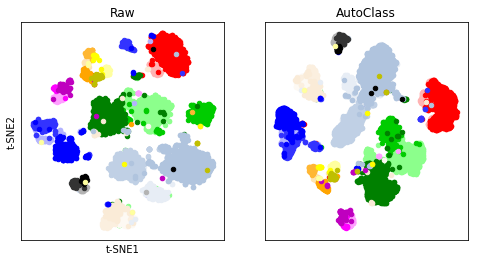

In [7]:
COL = ['red','green','antiquewhite','orange','blue','lightsteelblue','black','m','y']
fig = plt.figure(figsize=(8,4))
fig.add_subplot(121)
for i in unique_class:
    plt.scatter(tsne_raw[(Y==i)&(batchID==1),0],tsne_raw[(Y==i)&(batchID==1),1],s=20,
                            color=lighten_color(COL[i],0.3))
    plt.scatter(tsne_raw[(Y==i)&(batchID==2),0],tsne_raw[(Y==i)&(batchID==2),1],s=20,
                            color=lighten_color(COL[i],0.8))
    plt.scatter(tsne_raw[(Y==i)&(batchID==3),0],tsne_raw[(Y==i)&(batchID==3),1],s=20,
                            color=lighten_color(COL[i],1))
plt.xticks([],[])
plt.yticks([],[])
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
plt.title('Raw')
fig.add_subplot(122)
for i in unique_class:
    plt.scatter(tsne_auto[(Y==i)&(batchID==1),0],tsne_auto[(Y==i)&(batchID==1),1],s=20,
                            color=lighten_color(COL[i],0.3))
    plt.scatter(tsne_auto[(Y==i)&(batchID==2),0],tsne_auto[(Y==i)&(batchID==2),1],s=20,
                            color=lighten_color(COL[i],0.8))
    plt.scatter(tsne_auto[(Y==i)&(batchID==3),0],tsne_auto[(Y==i)&(batchID==3),1],s=20,
                            color=lighten_color(COL[i],1))
plt.xticks([],[])
plt.yticks([],[])
plt.title('AutoClass')

In [8]:
print('Raw data batch effect metrics:')
print(batch_clus(tsne_raw,Y,batchID))
print('AutoClass imputed data batch effect metrics:')
print(batch_clus(tsne_auto,Y,batchID))

Raw data batch effect metrics:
   1-ASW  1-ARI  1-NMI   1-PS
0  0.623   0.36  0.371  0.126
AutoClass imputed data batch effect metrics:
   1-ASW  1-ARI  1-NMI  1-PS
0  0.702  0.559  0.548  0.18


In [9]:
print('Raw data cell type separation metrics:')
print(celltype_clus(tsne_raw,Y))
print('AutoClass imputed data cell type separation metrics:')
print(celltype_clus(tsne_auto,Y))

Raw data cell type separation metrics:
     ASW    ARI    NMI     PS
0  0.351  0.583  0.769  0.886
AutoClass imputed data cell type separation metrics:
     ASW    ARI    NMI     PS
0  0.362  0.667  0.822  0.927


#### Marker genes analyses

In [10]:
genename = expr.columns.values[:-2]
markerratio_raw = []
markerratio_auto = []
markers = {'alpha':["GCG"   ,   "TTR"    ,  "IRX2"    , "SLC7A2" ,  "TM4SF4" ,  "NPNT"    ,
                    "RGS4"  ,   "KCTD12"  , "CRYBA2" ,  "MUC13"  ,  "CLU" ,     "PDK4"   , 
                    "PCSK2" ,   "TMEM176B"],
            'beta' : ["INS"   ,  "IAPP"   , "IGF2" ,   "DLK1" ,   "PDX1" ,   "ADCYAP1" ,"HADH"   ],
            'delta' : ["SST" ,   "LEPR"  , "RBP4" ,  "RGS2"   ,"SEC11C"],
            'gamma' : ["PPY"  ,  "STMN2" , "ARX" ,   "MEIS2" , "AQP3" ,  "DPYSL3"],
            'ductal' : [ "KRT19"  , "TACSTD2" ,"ANXA2" ,  "S100A10" ,"S100A11", "KRT17" ,  "KRT18" , 
                        "KRT7"  ,  "S100A16" ,"S100A14" ,"TPM1"   ],
            'acinar' : ["CTRB1"  ,  "CELA3A"  , "CELA3B"  , "CTRB2"  ,  "PLA2G1B" , "PRSS2"  , 
                        "SPINK1" ,  "CLPS"  ,   "CPA1" ,    "PRSS1"  ,  "CPA2" ,    "REG1A" ,  
                        "PNLIP"  ,  "SYCN"  ,   "PNLIPRP1", "CTRC" ,    "KLK1"    , "CELA2A" , "CPB1" ]}
cellname = ['alpha','beta','delta','gamma','ductal','acinar']

In [11]:
for cell in cellname:
    for gene in markers[cell]:
        if (gene in genename):
            markerratio_raw.append( np.mean(X_norm[celltype==cell,genename==gene]) /
                                    np.mean(X_norm[celltype!=cell,genename==gene]) )
            markerratio_auto.append( np.mean(imp_auto[celltype==cell,genename==gene]) /
                                    np.mean(imp_auto[celltype!=cell,genename==gene]) )

10.539449 13.267224944894348


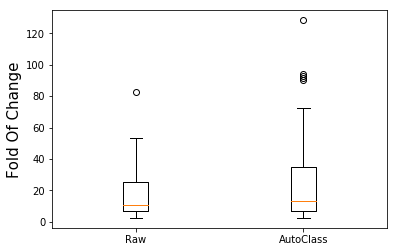

In [12]:
plt.boxplot([markerratio_raw,markerratio_auto],labels=['Raw','AutoClass'])
plt.ylabel('Fold Of Change',fontsize=15)
print(np.median(markerratio_raw),np.median(markerratio_auto))

In [13]:
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
t_raw,t_auto = [],[]
for cell in cellname:
    for gene in markers[cell]:
        if (gene in genename):
            t_raw.append(ttest_ind(X_norm[celltype==cell,genename==gene],
                                   X_norm[celltype!=cell,genename==gene])[0])
            t_auto.append(ttest_ind(imp_auto[celltype==cell,genename==gene],
                                    imp_auto[celltype!=cell,genename==gene])[0])


109.026056393154 204.02356041780752


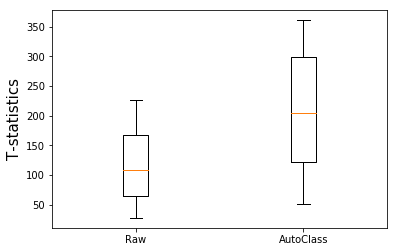

In [14]:
plt.boxplot([t_raw,t_auto],labels=['Raw','AutoClass'])
plt.ylabel('T-statistics',fontsize=15)
print(np.median(t_raw),np.median(t_auto))